# Lab 5 : Radial Basis Function

## Question 1 : Demonstrate the capability of an RBF network to model the XOR logic gate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinv

In [2]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([[0], [1], [1], [0]])

In [3]:
def rbf(x, c, s):
    return np.exp(-np.sum((x-c)**2) / (2 * s**2))

In [4]:
def rbf_network(X, Y, centers, sigma):
    G = np.zeros((X.shape[0], centers.shape[0]))
    for i in range(X.shape[0]):
        for j in range(centers.shape[0]):
            G[i, j] = rbf(X[i], centers[j], sigma)
    W = np.dot(pinv(G), Y)
    return W, centers, sigma

In [5]:
centers = X  # Use XOR inputs as centers
sigma = 0.5  # Set sigma value
W, centers, sigma = rbf_network(X, Y, centers, sigma)

In [6]:
x_vals = np.linspace(0, 1, 100)
y_vals = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x_vals, y_vals)
grid = np.c_[X1.ravel(), X2.ravel()]

In [7]:
G = np.zeros((grid.shape[0], centers.shape[0]))
for i in range(grid.shape[0]):
    for j in range(centers.shape[0]):
        G[i, j] = rbf(grid[i], centers[j], sigma)
predictions = np.dot(G, W)

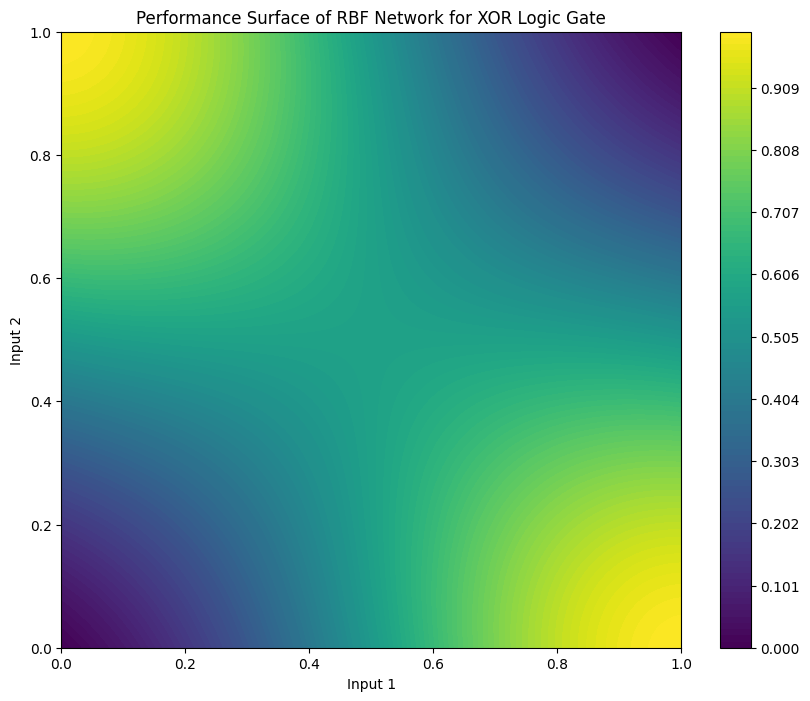

In [8]:
Z = predictions.reshape(X1.shape)
plt.figure(figsize=(10, 8))
plt.contourf(X1, X2, Z, levels=np.linspace(0, 1, 100), cmap='viridis')
plt.colorbar()
plt.title('Performance Surface of RBF Network for XOR Logic Gate')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.show()

## Question 2 : Use radial basis function neural network to separate classes in the Iris database

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [10]:
# Step 1: Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

In [11]:
# Step 2: Preprocess the data
## Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## One-hot encode the target labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

## Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

In [12]:
# Step 3: Construct the RBF Network
n_centers = 10  # Number of RBF centers

kmeans = KMeans(n_clusters=n_centers, random_state=42)
kmeans.fit(X_train)
centers = kmeans.cluster_centers_ # K-means clustering to find RBF centers

def rbf(x, centers, gamma=1.0):
    return np.exp(-gamma * np.linalg.norm(x - centers, axis=1) ** 2)

Phi_train = np.array([rbf(x, centers) for x in X_train]) # Construct design matrix for RBF

weights = np.linalg.pinv(Phi_train).dot(y_train) # Compute weights using linear regression (least squares)

In [13]:
# Step 4: Evaluate the model on the test set
Phi_test = np.array([rbf(x, centers) for x in X_test])
y_pred = Phi_test.dot(weights)
y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = np.argmax(y_test, axis=1) # Convert one-hot encoded y_test back to class labels

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Accuracy on the test set: 96.67%


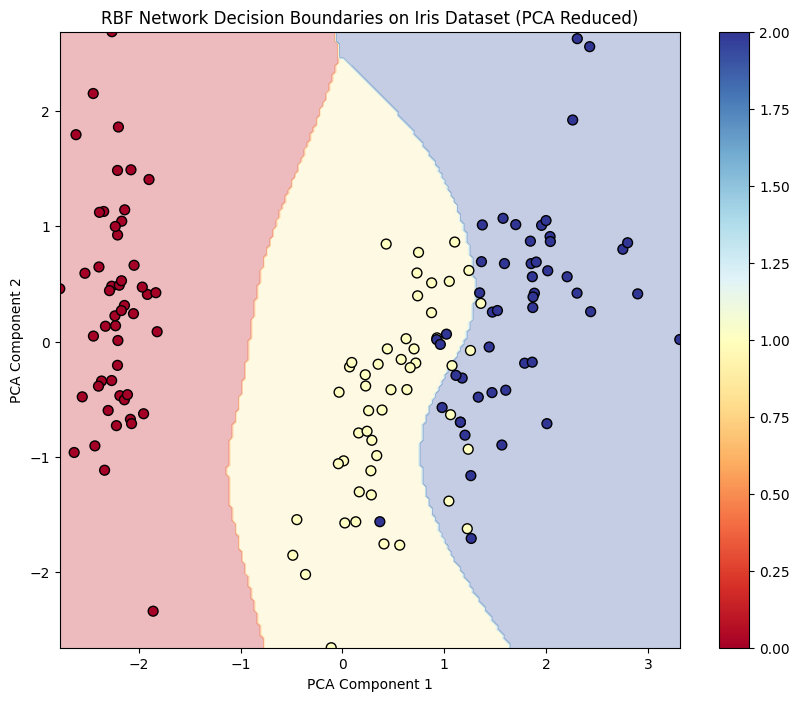

In [14]:
# Step 5: Visualize decision boundaries

## Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Refit the RBF network using the PCA-transformed data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_onehot, test_size=0.2, random_state=42)
kmeans.fit(X_train_pca)
centers_pca = kmeans.cluster_centers_

Phi_train_pca = np.array([rbf(x, centers_pca) for x in X_train_pca])
weights_pca = np.linalg.pinv(Phi_train_pca).dot(y_train_pca)

# Generate a grid of points
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min(), X_pca[:, 0].max(), 200),
                     np.linspace(X_pca[:, 1].min(), X_pca[:, 1].max(), 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Compute RBF responses for each point in the grid
Phi_grid_pca = np.array([rbf(x, centers_pca) for x in grid_points])
grid_predictions = Phi_grid_pca.dot(weights_pca)
grid_pred_classes = np.argmax(grid_predictions, axis=1)

# Plotting decision boundaries
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, grid_pred_classes.reshape(xx.shape), alpha=0.3, cmap='RdYlBu')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdYlBu', edgecolors='k', s=50)
plt.title("RBF Network Decision Boundaries on Iris Dataset (PCA Reduced)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()